# Bike route

We are a bike tour agency and our next trip will be from Dortmund to Bad Münstereifel in the beautiful Eifel. To get an idea of how the trip is going to be we would like to receive some information about the route. 

In [1]:
import folium
from folium import Map, Marker, FeatureGroup, LayerControl

from openrouteservice import client, geocode, directions, places

from pprint import pprint
#from shapely.geometry import Polygon, MultiPolygon, shape, mapping, LineString, Point
#from shapely import wkt

import numpy as np
from matplotlib import pylab

We will start with a nice map and the general route we are planning to do. Furthermore, let's have a first look at some basic information.

In [2]:
# Directions from Dortmund to Bad Münstereifel (Eifel)
api_key = '58d904a497c67e00015b45fc2a6b6872037d44119582ef40cdf264c4' # Provide your personal API key
clnt = client.Client(key=api_key) # Create client with api key

Dortmund = [7.46307760, 51.51194839]
Eifel = [6.763458, 50.563177]

cleaned_map = folium.Map(tiles='Stamen Toner', location=([51.086273, 7.165833]), zoom_start=9)
direct_params = {'coordinates': [Dortmund, Eifel],
                'profile': 'cycling-tour', # profile cycling-tour
                'format_out': 'geojson',
                'geometry': 'true',
                'instructions': 'false',
                 'elevation': 'true', 
                                   }
direct_request = clnt.directions(**direct_params) # Direction request
folium.GeoJson(direct_request).add_to(cleaned_map)

# Basic information
for info in direct_request['features'][0]['properties']['summary']:
    print('Distance: {:.2f} km \nDuration: {:.2f} hours'.format(info['distance']/1000, info['duration']/3600))
    print('Total elevation difference from start to destination: {:.2f} m.'.format(info['ascent']-info['descent']))

folium.Marker(list(reversed(Dortmund)), popup='Start - Dortmund').add_to(cleaned_map)
folium.Marker(list(reversed(Eifel)), popup='Destination - Eifel').add_to(cleaned_map)
cleaned_map

Distance: 143.81 km 
Duration: 9.27 hours
Total elevation difference from start to destination: 174.90 m.


The total elevation difference amounts 174.90 m. That is not much at all. It would be nice if we could get some more information about the elevation. 

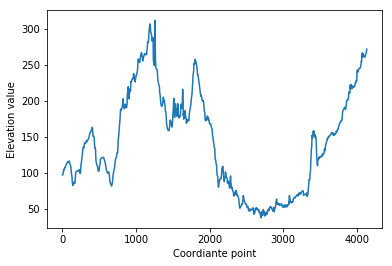

Elevation values:
  Lowest: 37.025
  Median: 137.699
  Highest: 312.092

The highest peak is at 312.091667 meter above zero with the coordinates [51.30836, 7.240676].


In [3]:
# The elevation value is saved in the coordinate paramter -> e.g. [lat, lon, elev]
elev_values = []
for value in direct_request['features'][0]['geometry']['coordinates']:
    elev_values.append(value[2])

# Plot elevation values
pylab.plot(elev_values)
pylab.xlabel('Coordiante point')
pylab.ylabel('Elevation value')
pylab.show()
print('Elevation values:\n  Lowest: {:.3f}\n  Median: {:.3f}\n  Highest: {:.3f}\n'.format(np.min(elev_values), np.median(elev_values), np.max(elev_values)))


# Highest peak
elev_array = np.array([elev_values])
for elev_value in direct_request['features'][0]['geometry']['coordinates']:
    if elev_value[2] == np.max(elev_array):
        peak_coords = [elev_value[1], elev_value[0]]
        folium.Marker(peak_coords, 
                      icon = folium.Icon(color='green'), 
                      popup = 'Highest elevation point').add_to(cleaned_map)    
        
print('The highest peak is at {} meter above zero with the coordinates {}.'.format(np.max(elev_array),peak_coords))

Can we get even some more information? Maybe the tour won't be that exhausting, like it looks like on the plot!


Let's get an overview of our route by the extra information parameter. We get information about the steepness, the suitability, the surface and the way category.
Further information about the response values: [**OpenRouteService - Documentation**](https://github.com/GIScience/openrouteservice-docs#routing-response)

In [4]:
# Delete elevation value for a better handeling
del direct_params['elevation'] 
direct_noelevation = clnt.directions(**direct_params)

# Request extra information
direct_params['extra_info'] = {'steepness','traildifficulty', 'suitability', 'surface', 'waycategory'}
del direct_params['format_out'] # Delete 'format_out' parameter for receiving extra information
direct_extra_request = clnt.directions(**direct_params)

We will have a closer look at the steepness values. Is the route steep? And if yes, which parts?

The steepness is declared in values from -5 to +5 and is connected to the way points. Therefore, we group the values into ascent, flat and descent (positive, zero and negative values) and combine these with the corresponding coordinates.

In [7]:
# Feature Groups
flat_group = FeatureGroup(name='Flat')
ascent_group = FeatureGroup(name='Ascent')
descent_group = FeatureGroup(name='Descent')

#grouped_values = [[],[],[]] 
grouped_values = []
grouped_coords = []
for value in direct_extra_request['routes']:
    steepness_values = value['extras']['steepness']['values']
    
    route_kombi = [steepness_values, direct_noelevation] # Combination of steepness_values and coordinates
    
    for value in route_kombi[0]:
        grouped_values.append([])
        if value[2] == 0: # flat
            grouped_values[0].append(value[0:2])
        if value[2] > 0: # ascent
            grouped_values[1].append(value[0:2])
        if value[2] < 0: # descent
            grouped_values[2].append(value[0:2])
            
    for l in range(len(grouped_values)):
        grouped_coords.append([])
        for i,j in grouped_values[l]: 
            coords = [coords['geometry']['coordinates'][i:j] for coords in route_kombi[1]['features']] # Receiving coordinates
            grouped_coords[l].append([(y,x) for x,y in coords[0]])
    folium.PolyLine(grouped_coords[0], color='green').add_to(flat_group)
    folium.PolyLine(grouped_coords[1], color='red').add_to(ascent_group)
    folium.PolyLine(grouped_coords[2], color='blue').add_to(descent_group)

flat_group.add_to(cleaned_map)
ascent_group.add_to(cleaned_map)
descent_group.add_to(cleaned_map)

# Steepness information summary
print('Steepness summary: \nNegative values indicate decline, positive incline.\n ')
for value in direct_extra_request['routes'][0]['extras']['steepness']['summary']:
    if value['amount'] > 10:
        print('{:.2f}% of the road has a value of {}.'.format(value['amount'], value['value']))
        

cleaned_map

Steepness summary: 
Negative values indicate decline, positive incline.
 
69.69% of the road has a value of 0.
14.88% of the road has a value of -1.
12.03% of the road has a value of 1.


Great, it seems like most of the way is more or less flat. Almost 70% to be correct. It looks like the journey won't be too exhausting. Nice for beginners. 

In the next step we like to know some more about the other information we have receivesd from the extra_info parameter. Here we are in particular interessted in what is making out the main part of the route. Therefore, we are just looking up the values which are appear in more than 40% of the route. #####

In [14]:
# Surface
print('Surface summary: \nThe surface value 3 stands for asphalt. ')
for value in direct_extra_request['routes'][0]['extras']['surface']['summary']:
    if value['amount'] > 40:
        print('{:.2f}% of the route has a surface value of {}.\n'.format(value['amount'], value['value']))

###
#print('Trail difficulty summary:')
#for value in direct_extra_request['routes'][0]['extras']['traildifficulty']['summary']:
 #   if value['amount'] > 50:
  #      print(value) # 
        #print('{:.2f}%')

# Suitability
print('Suitability summary: \nSuitability is ranked from 1 to 10, whereas 10 represents the best suitability.')
for value in direct_extra_request['routes'][0]['extras']['suitability']['summary']:
    if value['amount'] > 40:
        print('{:.2f}% of the route has a {} ranged suitabilty.\n'.format(value['amount'], value['value']))

# Way Category
print('Way Category summary:')
for value in direct_extra_request['routes'][0]['extras']['waycategory']['summary']:
    if value['amount'] > 40:
        print('{:.2f}% of the road is paved.'.format(value['amount']))

Surface summary: 
The surface value 3 stands for asphalt. 
80.06% of the route has a surface value of 3.

Suitability summary: 
Suitability is ranked from 1 to 10, whereas 10 represents the best suitability.
77.03% of the route has a 10 ranged suitabilty.

Way Category summary:
51.01% of the road is paved.


Further information about the response values: [**OpenRouteService - Documentation**](https://github.com/GIScience/openrouteservice-docs#routing-response).

## Geocoding

In [9]:
# Geocoding 
poi_dict = {'Kölner Dom'}

point_geom = []
address_request = geocode.pelias_search(client=clnt, text=poi_dict)
for l in address_request['features']:
    point = l['geometry']['coordinates']
    name = l['properties']['name']
    if name == 'Kölner Dom':
        folium.Marker(list(reversed(point)), 
                      icon = folium.Icon(color='green'), popup=name).add_to(cleaned_map)
cleaned_map

We can get some information about the available POIs in the desired region. Here we would like to know how many different historic places there are in Cologne. In particular we are interessted in monuments, ruins and citywalls. Furthermore, it is always good to know how many viewpoints there are.

In [10]:
# Isochrone Cologne (stats of pois)
iso_cologne_params = {'locations': [6.957972, 50.941338],
                    'profile': 'cycling-tour',
                    'range_type': 'distance',
                    'segments': 2000 # 
                   }
iso_cologne_request = clnt.isochrones(**iso_cologne_params)
folium.GeoJson(iso_cologne_request).add_to(cleaned_map)

#POI
poi_cologne_params = {'request': 'stats',
                     'geojson': iso_cologne_request['features'][0]['geometry'],
                     'filter_category_ids': [627, 240, 227, 243]} # 240 monument, 627 viewpoint, 227 city wall, 243 ruins
stats_cologne_request = clnt.places(**poi_cologne_params)

print('There are in total {} found places.\n'.format(stats_cologne_request['places']['total_count']))
pprint(stats_cologne_request['places']['historic']['categories'])
pprint(stats_cologne_request['places']['tourism']['categories'])

There are in total 22 found places.

{'citywalls': {'category_id': 227, 'count': 1},
 'monument': {'category_id': 240, 'count': 2},
 'ruins': {'category_id': 243, 'count': 10}}
{'viewpoint': {'category_id': 627, 'count': 9}}


Okay, so it is definitely worth to do a small tour to visit all the old POIs ruins.

In [11]:
def style_function(color):
    return lambda feature: dict(color=color)

poi_cologne_params['request'] = 'pois'
poi_cologne_params['filter_category_ids'] = [243]
poi_cologne_request = clnt.places(**poi_cologne_params)

poi_cologne_coords = []
for ruins in poi_cologne_request['features']:
    poi_coords = ruins['geometry']['coordinates']
    if 'name' in ruins['properties']['osm_tags']:
        name = ruins['properties']['osm_tags']['name']    
    folium.map.Marker(list(reversed(ruins['geometry']['coordinates'])),
                     icon=folium.Icon(color='white',
                                            icon_color='purple',
                                            icon='map-pin ',
                                            prefix='fa'
                                           ), popup=name).add_to(cleaned_map)

cleaned_map.add_child(folium.map.LayerControl())

In [ ]:
#####

In [60]:
from shapely.geometry import Point
# Create geometry of construction points 
point_geom = []
for point in poi_coords:
    poi_tup = tuple(point)
    poi_geom = Point(poi_tup)
    point_geom.append(poi_geom)
    
# Request route with avoiding construction points which are located on route    
for point in point_geom:
    if point.within(dilated_route): 
        point_coords = list(point.coords) # get point coordinates
        print(point_coords)

[(7.23065209999997, 51.31524010000003)]


In [60]:
try:
    listed_coord = []
    for coord in aoi_coords:
        listed_coord += [[round(coord[0],6), round(coord[1],6)]]


    json_coords = {
          "type": "FeatureCollection",
          "features": [{
              "type": "Feature",
              "properties": {},
              "geometry": {
                "type": "Polygon",
                "coordinates": [listed_coord]
              }}]}
except Exception as err:
    print(err)

In [66]:
aoi_geom = mapping(shape(poly))

In [68]:
try:
    poi_params = {'request': 'pois',
                 'geojson': aoi_geom,
                 'filter_category_ids': [240]} # monument
    poi_request = clnt.places(**poi_params)
except Exception as err:
    print(err)

Expecting value: line 1 column 1 (char 0)


In [52]:
wkt_str = 'Polygon ((13.43926404 52.48961046, 13.42040115 52.49586382, 13.42541101 52.48808523, 13.42368155 52.48635829, 13.40788599 52.48886084, 13.40852944 52.487142, 13.40745989 52.48614988, 13.40439187 52.48499746, 13.40154731 52.48500125, 13.40038591 52.48373202, 13.39423818 52.4838664, 13.39425346 52.48577149, 13.38629096 52.48582648, 13.38626853 52.48486362, 13.3715694 52.48495055, 13.37402099 52.4851697, 13.37416365 52.48771105, 13.37353615 52.48798191, 13.37539925 52.489432, 13.37643416 52.49167597, 13.36821531 52.49333093, 13.36952826 52.49886974, 13.37360623 52.50416333, 13.37497726 52.50337776, 13.37764916 52.5079675, 13.37893813 52.50693045, 13.39923153 52.50807711, 13.40022883 52.50938108, 13.40443425 52.50777471, 13.4052848 52.50821063, 13.40802944 52.50618019, 13.40997081 52.50692569, 13.41152096 52.50489127, 13.41407284 52.50403794, 13.41490921 52.50491634, 13.41760145 52.50417013, 13.41943091 52.50564912, 13.4230412 52.50498109, 13.42720031 52.50566607, 13.42940229 52.50857222, 13.45335235 52.49752496, 13.45090795 52.49710803, 13.44765912 52.49472124, 13.44497623 52.49442276, 13.43926404 52.48961046))'

aoi_geom = wkt.loads(wkt_str) # load geometry from WKT string

aoi_coords = list(aoi_geom.exterior.coords) # get coords from exterior ring
aoi_coords = [(y,x) for x,y in aoi_coords] # swap (x,y) to (y,x). Really leaflet?!
aoi_centroid = aoi_geom.centroid # Kreuzberg center for map cente

In [54]:
aoi_json = mapping(shape(aoi_geom))
query = {'request': 'pois',
        'geojson': aoi_json,
        'filter_category_ids': [569],
        'sortby': 'distance'}
pubs = clnt.places(**query)['features'] # Perform the actual request and get inner json